<a href="https://colab.research.google.com/github/vishalnadagiri/AutoCaption/blob/main/AutoCaptionCNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
import glob
import re

# Image data preparation and Image feature extraction

In [2]:
def extract_features(img_files):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    features = dict()
    for name in img_files:
        # filename = directory + '/' + name
        image = load_img(name, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
        # image = preprocess_input(image)
        feature = model.predict(image, verbose=0).reshape(4096,)

        image_id = name.split('/')[-1]

        features[image_id] = feature
    # print('>%s' % name)
    return features

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f"/content/drive/MyD"

'/content/drive/MyD'

In [4]:
csv_path = f"/content/drive/MyDrive/AutoCaption/dataset.xlsx"
imag_path = f"/content/drive/MyDrive/AutoCaption/images/" 
df = pd.read_excel(csv_path)
img_files = (glob.glob(imag_path+'*'))

In [5]:
features = extract_features(img_files)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

553467904/553467096 [==============================] - 4s 0us/step
Extracted Features: 500


# Tetxt Data prepparation

In [6]:
df.Description[0]

'This stylish foil print kurta from janasya is made of poly crepe and comes in an attractive peach color. It features 3/4 sleeve,round neck,a-line and it is calf length kurta that is suitable for casual occasions. Team it with matching leggings for a chic look.'

In [7]:
type(features)

dict

In [ ]:
features.keys()

In [9]:
df.columns

Index(['Title', 'Description', 'Material', 'Pattern', 'Neckline',
       'Image_Path'],
      dtype='object')

In [10]:
df.Image_Path[0]

'/images/pic_0.jpg'

In [11]:
df.Image_Path = df.Image_Path.apply(lambda x: x.split(f'/')[-1])

In [12]:
df.Image_Path[0]

'pic_0.jpg'

- Convert all words to lowercase.
- Remove all punctuation.
- Remove all words that are one character or less in length (e.g. ‘a’).
- Remove all words with numbers in them.

In [13]:
for des,im in zip(df.Description[:5],df.Image_Path[:5]):
    print(im ,des)
    print()
    print()

pic_0.jpg This stylish foil print kurta from janasya is made of poly crepe and comes in an attractive peach color. It features 3/4 sleeve,round neck,a-line and it is calf length kurta that is suitable for casual occasions. Team it with matching leggings for a chic look.


pic_1.jpg This check pattern top by Work Label is crafted in cotton. Featuring a bias check at the yoke and straight check pattern in bottom half, a smart round Neckline, 3/4th sleeves, this mid hip length top offers a stylish & comfortable fit. Style this top with a trouser/skirt and medium high heels for chic look at work. This top can also be styled with a pair of stud earrings and a pair your regular sneakers to attain a casual look.


pic_2.jpg Featuring elegant printed details, this off white top and skirt set from Jaipur Kurti makes a statement addition to your casual wardrobe. Style this set with a pair of high heels and statement accessories to complete the look.


pic_3.jpg Add an extra dose of style to your

In [14]:
#create a dictionary as key: image name and value: description
descriptions = {k : v for k,v in zip(df.Image_Path,df.Description) }

In [15]:
import string

def clean_descriptions(descriptions):
    '''
        Clean the text 
        1. split desc in into words
        2. make all char lower case 
        3. remove punctuations
        4. remove single chars
        5. remove non-numeric chars
    '''
    table = str.maketrans('', '', string.punctuation)
    for key, desc in descriptions.items():
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc = [word for word in desc if len(word)>1]
        desc = [word for word in desc if word.isalpha()]
        descriptions[key] =  'startseq ' + ' '.join(desc) + ' endseq'


clean_descriptions(descriptions)

In [16]:
descriptions['pic_0.jpg']

'startseq this stylish foil print kurta from janasya is made of poly crepe and comes in an attractive peach color it features sleeveround neckaline and it is calf length kurta that is suitable for casual occasions team it with matching leggings for chic look endseq'

In [17]:
def to_vocabulary(descriptions):

    all_desc = set()
    for key,desc in descriptions.items():
        # for d in descriptions[key]:
        all_desc.update(desc.split(' '))
    return all_desc


vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 1587


In [18]:
len(descriptions)

500

In [21]:
train_desc =dict()
test_desc = dict()
for key in list(features.keys())[:400]:
    if key in descriptions.keys():
        train_desc.update({key:descriptions[key]})

for key in list(features.keys())[400:]:
    if key in descriptions.keys():
        test_desc.update({key:descriptions[key]})

In [22]:
len(descriptions),len(features),len(train_desc),len(test_desc)

(500, 500, 400, 100)

In [23]:
list(features.keys())[:2]

['pic_1.jpg', 'pic_0.jpg']

In [24]:
for key in train_desc.keys():
    if key in test_desc.keys():
        print(key)
else:
     print('all pic are unique in train and test')

all pic are unique in train and test


In [25]:
def load_photo_features(filename, dataset):
	# load all features
	# all_features = load(open(filename, 'rb'))
	# filter 
    features = {}
    for k in dataset:
        features.update({k:filename[k]})
	# features = {k: filename[k] for k in dataset}
    return features

train_feat = load_photo_features(features, train_desc)
test_feat = load_photo_features(features, test_desc)

In [26]:
train_feat[list(train_feat.keys())[2]].shape

(4096,)

In [27]:
# train_fea =dict()
# test_fea = dict()
# for key in train_desc.keys():
#     if key in features.keys():
#         train_fea.update({key:features[key]})

# for key in test_desc.keys():
#     if key in features.keys():
#         test_fea.update({key:features[key]})

In [28]:
# for key in train_fea.keys():
#     if key in test_fea.keys():
#         print(key)
# else:
#      print('all pic are unique in train and test')

In [29]:
train_desc['pic_0.jpg']

'startseq this stylish foil print kurta from janasya is made of poly crepe and comes in an attractive peach color it features sleeveround neckaline and it is calf length kurta that is suitable for casual occasions team it with matching leggings for chic look endseq'

In [30]:
#convert desc to list and tokennize it
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        all_desc.append(descriptions[key])
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
# prepare tokenizer
tokenizer_train = create_tokenizer(train_desc)
vocab_size = len(tokenizer_train.word_index) + 1
max_len=max_length(train_desc)
print('train Vocabulary Size : %d' % vocab_size)

tokenizer_test = create_tokenizer(test_desc)
vocab_size_test = len(tokenizer_test.word_index) + 1
max_length_test =max_length(test_desc)
print('test Vocabulary Size: %d' % vocab_size_test)


train Vocabulary Size : 1443
test Vocabulary Size: 725


In [ ]:
tokenizer_train.texts_to_sequences([descriptions[list(descriptions.keys())[0]]])

In [34]:
def create_sequences(tokenizer, max_length_, descriptions, photos, vocab_size):#tokenizer, max_length, train_desc, train_fea, vocab_size
    X1, X2, y = list(), list(), list()
    '''X1 = image features X2=desc seq y=next word'''
    for key, desc in descriptions.items():
        seq = tokenizer.texts_to_sequences([desc])
        # print(seq)
        for i in range(1, len(seq[0])):
            # split into input and output pair
            in_seq, out_seq = seq[0][:i], seq[0][i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length_)[0]

            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            X1.append(photos[key])
            X2.append(in_seq)
            y.append(out_seq)
    
    return array(X1), array(X2), array(y)

In [36]:
(train_feat['pic_0.jpg'].shape)

(4096,)

In [37]:
features['pic_1.jpg'].shape

(4096,)

In [38]:
X1train.shape, X2train.shape , ytrain.shape

NameError: ignored

In [53]:
X1train, X2train, ytrain =create_sequences(tokenizer_train, max_len, train_desc, train_feat, vocab_size)
print(X1train.shape)
X1test, X2test, ytest = create_sequences(tokenizer_train, max_len, test_desc, test_feat, vocab_size)
print(X1test.shape)

print('''
1. max_length_train = {}
2. train_desc  len = {}
3. train_fea  len = {}
4. train_vocab_size = {}

5. max_length_test = {}
6. test_desc  len = {}
7. test_fea len = {}
8. test_vocab_size = {}
'''.format(max_len,len(train_desc),len(train_feat),vocab_size,max_length_test,len(test_desc),len(test_feat),vocab_size_test))


(13874, 4096)
(3381, 4096)

1. max_length_train = 83
2. train_desc  len = 400
3. train_fea  len = 400
4. train_vocab_size = 1443

5. max_length_test = 78
6. test_desc  len = 100
7. test_fea len = 100
8. test_vocab_size = 725



In [54]:
len(train_desc)

400

In [55]:
key_ = list(descriptions.keys())[0]
print(key_)
desc_ = descriptions[key_]
print(desc_)
seq_ = tokenizer_train.texts_to_sequences([desc_])
print(seq_,len(seq_))
print(len(desc_.split()),len(seq_[0]))
x1_,x2_,y_ = [],[],[]
for i in range(1,len(seq_[0])):
    in_seq_,out_seq_ = seq_[0][:i],seq_[0][i]
    in_seq_ = pad_sequences([in_seq_],maxlen=max_len)[0]
    out_seq_ = to_categorical([out_seq_],num_classes=vocab_size)[0]
    x1_.append(features[key_])
    x2_.append(in_seq_)
    y_.append(out_seq_)

print(array(x1_))

pic_0.jpg
startseq this stylish foil print kurta from janasya is made of poly crepe and comes in an attractive peach color it features sleeveround neckaline and it is calf length kurta that is suitable for casual occasions team it with matching leggings for chic look endseq
[[4, 3, 122, 407, 91, 249, 17, 604, 12, 128, 16, 605, 60, 1, 163, 13, 41, 606, 357, 358, 19, 30, 818, 819, 1, 19, 12, 820, 171, 249, 61, 12, 607, 7, 47, 289, 87, 19, 2, 325, 359, 7, 84, 15, 5]] 1
45 45
[[0.        0.        0.        ... 0.        0.        4.6263666]
 [0.        0.        0.        ... 0.        0.        4.6263666]
 [0.        0.        0.        ... 0.        0.        4.6263666]
 ...
 [0.        0.        0.        ... 0.        0.        4.6263666]
 [0.        0.        0.        ... 0.        0.        4.6263666]
 [0.        0.        0.        ... 0.        0.        4.6263666]]


In [56]:
def define_model(vocab_size, max_length_dm):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length_dm,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [57]:
#monitor the minimum loss on the validation dataset and save the model to a file
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [58]:
model = define_model(vocab_size, max_len)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 83, 256)      369408      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [59]:
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2,callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Epoch 1/20
434/434 - 85s - loss: 5.7376 - val_loss: 5.0669

Epoch 00001: val_loss improved from inf to 5.06692, saving model to model-ep001-loss5.738-val_loss5.067.h5
Epoch 2/20
434/434 - 79s - loss: 4.9728 - val_loss: 4.5255

Epoch 00002: val_loss improved from 5.06692 to 4.52547, saving model to model-ep002-loss4.973-val_loss4.525.h5
Epoch 3/20
434/434 - 78s - loss: 4.2496 - val_loss: 3.9985

Epoch 00003: val_loss improved from 4.52547 to 3.99849, saving model to model-ep003-loss4.250-val_loss3.998.h5
Epoch 4/20
434/434 - 78s - loss: 3.6024 - val_loss: 3.7314

Epoch 00004: val_loss improved from 3.99849 to 3.73135, saving model to model-ep004-loss3.602-val_loss3.731.h5
Epoch 5/20
434/434 - 79s - loss: 3.0948 - val_loss: 3.6101

Epoch 00005: val_loss improved from 3.73135 to 3.61007, saving model to model-ep005-loss3.095-val_loss3.610.h5
Epoch 6/20
434/434 - 78s - loss: 2.6550 - val_loss: 3.6006

Epoch 00006: val_loss improved from 3.61007 to 3.60059, saving model to model-ep006-loss2

In [60]:
model.save('image_desc_loss_0.362_vslloss_5.91.h5')

# Model Evaluation

# Model Testing
- generate description for given url

In [63]:
url = r'https://images-na.ssl-images-amazon.com/images/I/81UZYparZfL._UL1500_.jpg'


In [72]:
import requests
import os
img_data = requests.get(url).content
if not os.path.exists('downloaded_image'):
    os.makedirs('downloaded_image')
else:
    img_name=os.getcwd()+'/downloaded_image'+'/image_name.jpg'
    with open(img_name, 'wb') as handler:
        handler.write(img_data)

In [77]:
dwn_img = os.getcwd()+'/downloaded_image'+'/image_name.jpg'

this black floral printed dress by attic ritu ritu kumar is crafted in satin and features vneck sleeves with tie up belt and regular fit style this dress with pair of high heels and fine accessories to complete the look endseq


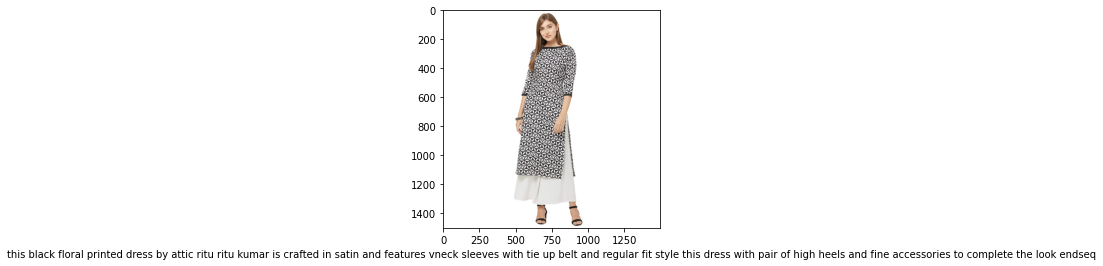

In [108]:
from keras.models import load_model
from numpy import argmax
import cv2
import matplotlib.pyplot as plt
import re
pattern = re.compile(r"\b(" + "|".join(['startseq','endseq']) + ")\\W", re.I)

def extract_features(filename):
	model = VGG16()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	image = load_img(filename, target_size=(224, 224))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = model.predict(image, verbose=0).reshape(1,4096)
	return feature
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text
 
 #with model val_loss 3.601
max_length = 34
model = load_model('model-ep006-loss2.655-val_loss3.601.h5')#
photo = extract_features(dwn_img)
description = generate_desc(model, tokenizer_train, photo, max_len)
desc = pattern.sub("", description)
imag = cv2.imread(dwn_img)
imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
plt.imshow(imag)
plt.xlabel(desc)
print(desc)

blue polyester georgette maxi dress polyester knit lining inside for comfort overlapping vneckline with tie up detailing at bust side pockets center front button placket for fastening and ease endseq


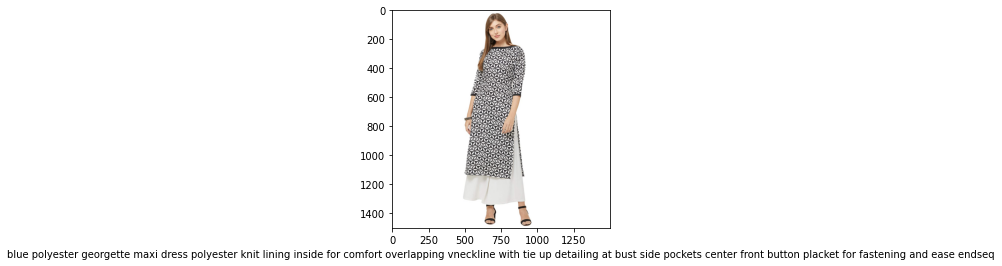

In [107]:
#with end model trained for all epochs
max_length = 34
model = load_model('image_desc_loss_0.362_vslloss_5.91.h5')
photo = extract_features(dwn_img)
description = generate_desc(model, tokenizer_train, photo, max_len)
desc = pattern.sub("", description)
imag = cv2.imread(dwn_img)
imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
plt.imshow(imag)
plt.xlabel(desc)
print(desc)

## WIth above two result we can say that model with low val_loss gives a little acceptable descriptions